# Modeling and Evaluation

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, precision_score,recall_score, confusion_matrix

from sklearn.metrics.pairwise import cosine_similarity

## Modeling

In [2]:
# read in data from csv with cluster labels
songs= pd.read_csv("../data/spotify_songs_clustered.csv")
songs.head()

,song,artist,album,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature,kmeans_cluster,dbscan_cluster
0,...Ready For It?,Taylor Swift,...Ready For It?,2017-09-03,0.615,0.779,2,-6.454,1,0.1350,0.0665,0.000000,0.1550,0.453,160.000,208198,4,7,0
1,Life Changes,Thomas Rhett,Life Changes,2017-09-08,0.687,0.845,7,-4.370,1,0.0576,0.1000,0.000000,0.0452,0.809,87.972,190227,4,0,0
2,24K Magic,Bruno Mars,24K Magic,2016-11-17,0.818,0.803,1,-4.282,1,0.0797,0.0340,0.000000,0.1530,0.632,106.970,225983,4,0,0
3,Galway Girl,Ed Sheeran,÷ (Deluxe),2017-03-03,0.624,0.876,9,-3.374,1,0.1000,0.0735,0.000000,0.3270,0.781,99.943,170827,4,2,0
4,Photograph,Ed Sheeran,x (Deluxe Edition),2014-06-21,0.614,0.379,4,-10.480,1,0.0476,0.6070,0.000464,0.0986,0.201,107.989,258987,4,3,0


In [3]:
# make function to evaluate model
def model_metrics(name, y_test, y_pred):
    """
    This function provides testing evaluation metrics for a classification model.
    Parameters:
        name (str): The name of the model.
        y_test (array): The true labels from the testing data.
        y_pred (array): The predicted labels created by the model.

    The function then returns a dictionary with these evaluation metrics: accuracy, precision, recall, f1_score
    """
    
    metrics_dict= {}
    accuracy= accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    metrics_dict["model"] = name
    metrics_dict["accuracy"] = accuracy
    metrics_dict["precision"] = precision
    metrics_dict["recall"] = recall
    metrics_dict["f1_score"] = f1
    return metrics_dict

### Multiclass Classification Modeling

Given a new song, we want to be able to classify the song into the appropriate cluster. In this section, we will find the best model at classifying a song into the appropriate cluster.

In [4]:
features= songs.drop(columns=["song", "artist", "album", 
                              "release_date", "kmeans_cluster", "dbscan_cluster"]).columns.to_list()
features

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration',
 'time_signature']

In [5]:
# using kmeans clusters
X= songs[features]
y= songs["kmeans_cluster"]

y.value_counts(normalize= True) # will be stratifying in train test split bc of imbalanced data

7    0.266334
0    0.248412
3    0.154038
2    0.132373
4    0.058530
5    0.057055
8    0.044578
1    0.035163
6    0.003516
Name: kmeans_cluster, dtype: float64

In [6]:
# split into train and test 
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state= 13, stratify= y)

**Logistic Regression**

In [7]:
pipe1 = Pipeline([
    ("sc", StandardScaler()),
    ("logreg", LogisticRegression(max_iter= 1000, random_state= 13))
])
pipe1.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=13))])

In [8]:
logreg_preds= pipe1.predict(X_test)

In [9]:
pipe1.score(X_train, y_train)

0.9823049001814882

In [10]:
pipe1.score(X_test, y_test)

0.9773139745916516

**These two scores are pretty close, so I don't feel the need to gridsearch.**

In [11]:
model_metrics("Logistic Regression", y_test, logreg_preds)

{'model': 'Logistic Regression',
 'accuracy': 0.9773139745916516,
 'precision': 0.9774634372221589,
 'recall': 0.9773139745916516,
 'f1_score': 0.9773247671957884}

In [12]:
# saving model metrics into a list
model_metrics_list= []
model_metrics_list.append(model_metrics("Logistic Regression", y_test, logreg_preds))

**Random Forest**

In [13]:
pipe2 = Pipeline([
    ("sc", StandardScaler()),
    ("rf", RandomForestClassifier(random_state= 13))
])
pipe2.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=13))])

In [14]:
rf_preds= pipe2.predict(X_test)

In [15]:
pipe2.score(X_train, y_train)

1.0

In [16]:
pipe2.score(X_test, y_test)

0.9546279491833031

There is overfitting. Let's try gridsearching.

In [17]:
pipe2_params= {
    "rf__n_estimators": [100, 200, 250],
    "rf__max_depth": [None, 1, 3, 5, 10],
    "rf__min_samples_leaf": range(1, 6)
}

gs2= GridSearchCV(pipe2, param_grid= pipe2_params, cv= 5, n_jobs= -1)
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 1, 3, 5, 10],
                         'rf__min_samples_leaf': range(1, 6),
                         'rf__n_estimators': [100, 200, 250]})

In [18]:
gs2.score(X_train, y_train)

1.0

In [19]:
gs2.score(X_test, y_test)

0.955989110707804

In [20]:
gs2.best_params_

{'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 250}

In [21]:
gs2_preds= gs2.predict(X_test)

In [22]:
model_metrics("Random Forest GS", y_test, gs2_preds)

{'model': 'Random Forest GS',
 'accuracy': 0.955989110707804,
 'precision': 0.956329173620452,
 'recall': 0.955989110707804,
 'f1_score': 0.9559452981458785}

In [23]:
model_metrics_list.append(model_metrics("Random Forest GS", y_test, gs2_preds))

This model is not better than our logistic regression model, even after gridsearching.

**Gradient Boosting**

In [24]:
pipe3 = Pipeline([
    ("sc", StandardScaler()),
    ("gb", GradientBoostingClassifier(random_state= 13))
])
pipe3.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('gb', GradientBoostingClassifier(random_state=13))])

In [25]:
gb_preds = pipe3.predict(X_test)

In [26]:
pipe3.score(X_train, y_train)

0.999697519661222

In [27]:
pipe3.score(X_test, y_test)

0.9637023593466425

There is some overfitting happening and these scores are not better than the logistic regression model. We can try gridsearching.

In [28]:
pipe3_params= {
    "gb__n_estimators": [100, 200, 250],
    "gb__max_depth": [2, 3, 4],
    "gb__learning_rate": [0.5, 1.0]
}

gs3= GridSearchCV(pipe3, param_grid= pipe3_params, cv= 3, n_jobs= -1)
gs3.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.5, 1.0],
                         'gb__max_depth': [2, 3, 4],
                         'gb__n_estimators': [100, 200, 250]})

In [29]:
gs3.score(X_train, y_train)

1.0

In [30]:
gs3.score(X_test, y_test)

0.9627949183303085

In [31]:
gs3.best_params_

{'gb__learning_rate': 0.5, 'gb__max_depth': 2, 'gb__n_estimators': 200}

In [32]:
gs3_preds= gs3.predict(X_test)

In [33]:
model_metrics("Gradient Boosting GS", y_test, gs3_preds)

{'model': 'Gradient Boosting GS',
 'accuracy': 0.9627949183303085,
 'precision': 0.9631014896484845,
 'recall': 0.9627949183303085,
 'f1_score': 0.9628372350423716}

In [34]:
model_metrics_list.append(model_metrics("Gradient Boosting GS", y_test, gs3_preds))

The grisearching made it even more overfit and the test score is a little worse.

**Stacking**

I will be creating a stacked model using the three estimators above and the parameters that gave the best results.

In [35]:
stack_estimators = [
    ('logreg', LogisticRegression(max_iter= 1000, random_state= 13)),
    ('rf', RandomForestClassifier(random_state= 13, n_estimators= 250)),
    ('gb', GradientBoostingClassifier(random_state= 13))
]

In [36]:
pipe4 = Pipeline([
    ("sc", StandardScaler()),
    ("stack",  StackingClassifier(estimators= stack_estimators, final_estimator= LogisticRegression(max_iter= 1000, random_state= 13)))
])
pipe4.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('stack',
                 StackingClassifier(estimators=[('logreg',
                                                 LogisticRegression(max_iter=1000,
                                                                    random_state=13)),
                                                ('rf',
                                                 RandomForestClassifier(n_estimators=250,
                                                                        random_state=13)),
                                                ('gb',
                                                 GradientBoostingClassifier(random_state=13))],
                                    final_estimator=LogisticRegression(max_iter=1000,
                                                                       random_state=13)))])

In [37]:
pipe4.score(X_train, y_train)

1.0

In [38]:
pipe4.score(X_test, y_test)

0.9823049001814882

In [39]:
stack_preds= pipe4.predict(X_test)

In [40]:
model_metrics("Stacked", y_test, stack_preds)

{'model': 'Stacked',
 'accuracy': 0.9823049001814882,
 'precision': 0.9824615739137817,
 'recall': 0.9823049001814882,
 'f1_score': 0.9823229228804702}

In [41]:
model_metrics_list.append(model_metrics("Stacked", y_test, stack_preds))

In [42]:
# making dataframe for all the model metrics
model_metrics_df= pd.DataFrame(columns= ["model", "accuracy", "precision", "recall", "f1_score"])

for eval_dict in model_metrics_list:
    model_df= pd.DataFrame(eval_dict, index=[0])
    model_metrics_df = pd.concat([model_metrics_df, model_df], ignore_index= True)
    
model_metrics_df.sort_values(by= "accuracy", ascending= False)

,model,accuracy,precision,recall,f1_score
3,Stacked,0.982305,0.982462,0.982305,0.982323
0,Logistic Regression,0.977314,0.977463,0.977314,0.977325
2,Gradient Boosting GS,0.962795,0.963101,0.962795,0.962837
1,Random Forest GS,0.955989,0.956329,0.955989,0.955945


By looking at all these evaluation metrics, we can see that our stacked model performs the best across all the metrics on our testing data set. I will move forward with this stacked model.

We can take a closer look at the stacked model by calculating the confusion matrix.

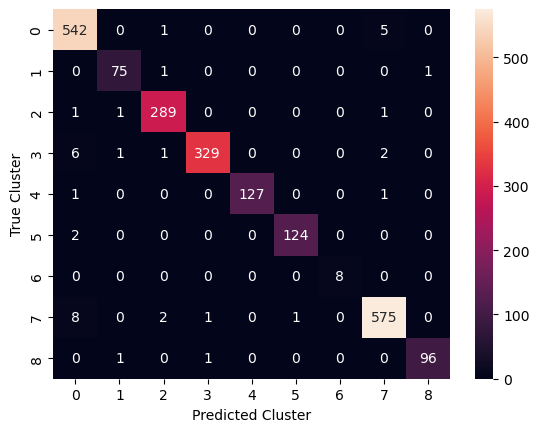

In [43]:
# making confusion matrix
cm= confusion_matrix(y_test, stack_preds)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.show();

It looks like when the model is mispredicting it is choosing to place the song in either cluster 0 or cluster 7, which makes sense because those clusters have the most songs in our data. The imbalance of classes for clusters is evident here.

### Recommender Model

Now, I will make a recommender model that will calculate cosine similarties.

In [44]:
# choosing columns for similarity calculation
recommender_features= songs.drop(columns=["song", "artist", "album", 
                              "release_date", "duration", "dbscan_cluster"]).columns.to_list()
recommender_features

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'kmeans_cluster']

In [45]:
recommender_df= songs[recommender_features]
recommender_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,kmeans_cluster
0,0.615,0.779,2,-6.454,1,0.1350,0.0665,0.000000,0.1550,0.453,160.000,4,7
1,0.687,0.845,7,-4.370,1,0.0576,0.1000,0.000000,0.0452,0.809,87.972,4,0
2,0.818,0.803,1,-4.282,1,0.0797,0.0340,0.000000,0.1530,0.632,106.970,4,0
3,0.624,0.876,9,-3.374,1,0.1000,0.0735,0.000000,0.3270,0.781,99.943,4,2
4,0.614,0.379,4,-10.480,1,0.0476,0.6070,0.000464,0.0986,0.201,107.989,4,3


In [46]:
sc= StandardScaler()
recommender_df_sc= sc.fit_transform(recommender_df)

In [47]:
# create similarity matrix
similarity_matrix = cosine_similarity(recommender_df_sc)

In [48]:
recommender = pd.DataFrame(similarity_matrix, index=songs["song"], columns=songs["song"])
recommender.head()

song,...Ready For It?,Life Changes,24K Magic,Galway Girl,Photograph,Havana (feat. Young Thug),When I Was Your Man,Gonna Fly Now,Don't Wanna Know (feat. Kendrick Lamar),Thinking out Loud,...,??? (Bonus Track),Sacrificed Sons,Saddle Tramp,"Remember the Future, Pt. 2",Alice's Restaurant Massacree,"Remember the Future, Pt. 1",Funeral For A Friend / Love Lies Bleeding,Fool's Overture,Heart of the Sunrise - 2003 Remaster,Venus And Mars / Rock Show / Jet - Live / Remastered
song,,,,,,,,,,,,,,,,,,,,,
...Ready For It?,1.000000,-0.223978,0.159074,-0.074019,-0.214015,-0.062589,-0.301808,-0.561810,0.186539,-0.241776,...,-0.277532,0.322713,-0.321155,-0.468991,-0.224822,-0.365288,0.094903,0.031403,0.304360,-0.023317
Life Changes,-0.223978,1.000000,0.702614,0.704423,-0.201899,-0.020149,-0.010263,-0.202358,0.215694,0.376685,...,-0.465632,-0.548901,-0.319620,-0.397770,-0.123575,-0.151712,-0.540901,-0.465071,-0.402840,-0.277547
24K Magic,0.159074,0.702614,1.000000,0.448286,-0.103815,-0.078258,0.079545,-0.551772,0.121497,0.514727,...,-0.645977,-0.441713,-0.314590,-0.485104,-0.113701,-0.549842,-0.675472,-0.310496,-0.274072,-0.011716
Galway Girl,-0.074019,0.704423,0.448286,1.000000,-0.523862,-0.110006,-0.347194,-0.343161,0.129713,0.105421,...,-0.539503,-0.250535,-0.252012,-0.670342,0.308882,-0.278315,-0.215496,-0.703819,-0.447748,0.262313
Photograph,-0.214015,-0.201899,-0.103815,-0.523862,1.000000,0.012919,0.837641,0.028698,0.340856,0.532042,...,0.530526,-0.392953,-0.300090,0.358790,0.132885,0.333671,-0.346019,0.732573,-0.002267,-0.192612


#### Constructing the model into a function

In [60]:
def get_recommendations(your_song, num_recommendations):
    
    
    '''
    This function gets song recommendations based on a given song and the desired number of recommendations.
    It takes in a song name (your_song) and the number of songs you want recommended (num_recommendations).
    It returns a dataframe with the recommended song names, respective artists, and similarity scores (in order by similarity score descending)
    '''
    # find all songs that contain the song input
    matching_songs = songs.loc[songs["song"].str.contains(your_song, case=False), "song"]
    
    if matching_songs.empty:
            print(f"It appears that we do not have any matching songs in our dataframe for: {your_song}.\nPlease try another song!")
            print()
    else:      
        for song in matching_songs:
            print(f"Recommendations for {song}")

            try:
                # get song's similarity scores from the recommender and sort descending
                sorted_similarity_scores = recommender.loc[song].sort_values(ascending=False)

                # get the top n songs from the sorted scores
                top_recommendations = sorted_similarity_scores[1:num_recommendations + 1].reset_index()
                top_recommendations.columns = ["recommended song", "similarity score"]

                recommendations = pd.merge(top_recommendations, songs, left_on="recommended song", right_on="song")
                recommendations = recommendations[["recommended song", "artist", "similarity score"]]

                print(recommendations)
                print("")

            # in case no songs found containing the song input
            except KeyError:
                print("No recommendations found for", song)
                print()

#### Examples of the recommender function in action!

In [61]:
get_recommendations("when i was your man", 10)

Recommendations for When I Was Your Man
      recommended song           artist  similarity score
0        Sing Together            Train          0.979379
1           Dirty Work       Steely Dan          0.971719
2  Bloom - Bonus Track  The Paper Kites          0.967229
3              Perfekt           Bendik          0.966851
4    What Am I To You?      Norah Jones          0.966176
5               Ho Hey    The Lumineers          0.965025
6              One Day       Tate McRae          0.964515
7          Count on Me       Bruno Mars          0.962009
8       I Hung My Head      Johnny Cash          0.955586
9         Sweet Louise        Passenger          0.955227



In [62]:
get_recommendations("stay with me", 10)

Recommendations for Stay With Me
                 recommended song                artist  similarity score
0                   Blood Stutter        Handsome Ghost          0.967303
1                  Oh Ms Believer     Twenty One Pilots          0.966553
2             I Won't Tell a Soul          Charlie Puth          0.962002
3                        Homesick  Kings of Convenience          0.955392
4                            Lost             Liza Anne          0.953457
5                         Perfekt                Bendik          0.947825
6  It's All Coming Back to Me Now           Céline Dion          0.939375
7                   Jar of Hearts       Christina Perri          0.924217
8          Merry Little Christmas          Why Don't We          0.922970
9                        Marianna   Ingrid Helene Håvik          0.922125



In [66]:
# example with multiple matching songs
get_recommendations("one dance", 10)

Recommendations for One Dance
                  recommended song         artist  similarity score
0            I Don't Fuck With You       Big Sean          0.976151
1                   In My Feelings          Drake          0.926173
2                    Dj Turn It Up  Heretic Klick          0.925024
3  Outta My Head (with John Mayer)         Khalid          0.921419
4                Ready To Love You      HEDEGAARD          0.906303
5                     It Wasn't Me         Shaggy          0.898671
6    Decisions (feat. Maia Wright)          KREAM          0.897975
7                     It's Alright   Matt and Kim          0.886191
8               I'd Be Jealous Too   Dustin Lynch          0.883109
9                     By The River      Klingande          0.882705

Recommendations for Just One Dance
                             recommended song                  artist  \
0                             Revolving Doors                Gorillaz   
1                        Loca (feat. El 

In [67]:
get_recommendations("we the people", 10)

It appears that we do not have any matching songs in our dataframe for: we the people.
Please try another song!



From these examples, it looks like the recommender does good, but could definitely be better. 